In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy  # Add import for entropy function
from environments_sb3 import SBEOS_Environment

In [2]:
import gym 
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy
#from stable_baselines3.ppo import MlpLstmPolicy
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import MlpLstmPolicy



In [3]:
# class RewardAccuracyLogger(BaseCallback):
#     def __init__(self, eval_env, eval_freq=1000, verbose=0):
#         super().__init__(verbose)
#         self.eval_env = eval_env
#         self.eval_freq = eval_freq
#         self.rewards = []
#         self.accuracies = []
#         self.losses = []
#         self.cm_list = []

#     def _on_step(self):
#         if self.n_calls % self.eval_freq == 0:
#             obs, _ = self.eval_env.reset()
#             done = False
#             states = None
#             ep_rewards = []
#             y_true = []
#             y_pred = []

#             while not done:
#                 action, states = self.model.predict(obs, state=states, deterministic=True)
#                 obs, reward, done, _, info = self.eval_env.step(action)
#                 ep_rewards.append(reward)
#                 y_true.append(info["state"])
#                 y_pred.append(int(action))
            
#             acc = accuracy_score(y_true, y_pred)
#             cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

#             self.rewards.append(np.sum(ep_rewards))
#             self.accuracies.append(acc)
#             self.cm_list.append(cm)

#         return True
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

class RewardAccuracyLogger(BaseCallback):
    def __init__(self, eval_env, eval_freq=1000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.accuracies = []
        self.confusion_matrices = []

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            obs, _ = self.eval_env.reset()
            done, state = False, None
            lstm_state = None
            episode_starts = True
            preds, labels = [], []
            total_reward = 0

            for _ in range(self.eval_env.max_timesteps):
                action, lstm_state = self.model.predict(
                    obs,
                    state=lstm_state,
                    episode_start=np.array([episode_starts]),
                    deterministic=True
                )
                obs, reward, terminated, truncated, info = self.eval_env.step(action)
                done = terminated or truncated
                total_reward += reward
                preds.append(int(action))
                labels.append(info["state"])
                episode_starts = done
                if done:
                    break

            acc = accuracy_score(labels, preds)
            cm = confusion_matrix(labels, preds, labels=[0, 1])

            self.episode_rewards.append(total_reward)
            self.accuracies.append(acc)
            self.confusion_matrices.append(cm)

            if self.verbose:
                print(f"Eval Reward: {total_reward}, Accuracy: {acc}")
        return True


In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from sb3_contrib.ppo_recurrent.policies import RecurrentActorCriticPolicy

# def train():
#     env = DummyVecEnv([lambda: Monitor(SBEOS_Environment())])
#     eval_env = SBEOS_Environment(max_timesteps=200)

#     # model = PPO(
#     #     policy=MlpLstmPolicy,
#     #     env=env,
#     #     verbose=1,
#     #     tensorboard_log="./ppo_sbeos_tensorboard/",
#     #     n_steps=128,
#     #     batch_size=64,
#     #     n_epochs=4,
#     #     learning_rate=2.5e-4,
#     #     gamma=0.99,
#     #     gae_lambda=0.95,
#     #     clip_range=0.2,
#     #     ent_coef=0.01,
#     #     device='cuda' if torch.cuda.is_available() else 'cpu',
#     # )
#     model = RecurrentPPO(
#     policy=RecurrentActorCriticPolicy,
#     env=env,
#     verbose=1,
#     n_steps=128,
#     batch_size=64,
#     gae_lambda=0.95,
#     gamma=0.99,
#     n_epochs=4,
#     ent_coef=0.01,
#     learning_rate=3e-4,
#     clip_range=0.2,
#     device='cuda' if torch.cuda.is_available() else 'cpu'
# )

#     logger = RewardAccuracyLogger(eval_env=eval_env, eval_freq=1000)
#     model.learn(total_timesteps=100_000, callback=logger)

#     model.save("ppo_sbeos_lstm_model")

#     return logger

# def plot_metrics(logger):
#     fig, axs = plt.subplots(2, 2, figsize=(14, 10))

#     axs[0, 0].plot(logger.rewards)
#     axs[0, 0].set_title("Episode Rewards")
#     axs[0, 0].set_xlabel("Evaluation Steps")
#     axs[0, 0].set_ylabel("Reward")

#     axs[0, 1].plot(logger.accuracies)
#     axs[0, 1].set_title("Accuracy")
#     axs[0, 1].set_xlabel("Evaluation Steps")
#     axs[0, 1].set_ylabel("Accuracy")

#     avg_cm = np.mean(logger.cm_list, axis=0)
#     sns.heatmap(avg_cm, annot=True, fmt='d', ax=axs[1, 0], cmap="Blues")
#     axs[1, 0].set_title("Avg Confusion Matrix")
#     axs[1, 0].set_xlabel("Predicted")
#     axs[1, 0].set_ylabel("Actual")

#     axs[1, 1].axis('off')

#     plt.tight_layout()
#     plt.show()

# def test_model():
#     model = PPO.load("ppo_sbeos_lstm_model", device="cuda" if torch.cuda.is_available() else "cpu")
#     env = SBEOS_Environment(max_timesteps=200)
#     obs, _ = env.reset()
#     done = False
#     rewards = []
#     y_true = []
#     y_pred = []
#     states = None

#     while not done:
#         action, states = model.predict(obs, state=states, deterministic=True)
#         obs, reward, done, _, info = env.step(action)
#         rewards.append(reward)
#         y_true.append(info["state"])
#         y_pred.append(int(action))

#     acc = accuracy_score(y_true, y_pred)
#     cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

#     print(f"Test Accuracy: {acc:.4f}")
#     print("Test Confusion Matrix:")
#     print(cm)

#     sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")
#     plt.title("Confusion Matrix (Test)")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()
def train():
    env = DummyVecEnv([lambda: Monitor(SBEOS_Environment(max_timesteps=200,window_size=20))])
    eval_env = SBEOS_Environment(max_timesteps=200,window_size=20)

    model = RecurrentPPO(
    policy=RecurrentActorCriticPolicy,
    env=env,
    verbose=1,
    n_steps=256,                 # Sequence length for rollouts
    batch_size=128,             # Effective batch size for update
    gae_lambda=0.95,            # GAE lambda
    gamma=0.99,                 # Discount factor
    n_epochs=10,                # Update epochs
    ent_coef=0.005,             # Exploration weight
    learning_rate=2.5e-4,       # Learning rate
    clip_range=0.15,            # PPO clipping
    max_grad_norm=0.5,          # Gradient clipping
    vf_coef=0.5,                # Value loss coefficient
    policy_kwargs=dict(
        lstm_hidden_size=128,   # LSTM hidden layer size
        shared_lstm=False,       # Share LSTM across actor and critic
        ortho_init=True,
        enable_critic_lstm=True,# Orthogonal weight initialization
    ),
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

    logger = RewardAccuracyLogger(eval_env=eval_env, eval_freq=1000)
    model.learn(
    total_timesteps=20_000,     # Better convergence
    callback=logger,
    log_interval=10,
    progress_bar=True
)
    model.save("recurrent_ppo_sbeos_model")
    return logger

import matplotlib.pyplot as plt

def plot_metrics(logger):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(logger.episode_rewards)
    plt.title("Episode Rewards")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Reward")

    plt.subplot(1, 2, 2)
    plt.plot(logger.accuracies)
    plt.title("Accuracy")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Accuracy")

    plt.show()

    # Confusion matrix (last one)
    if logger.confusion_matrices:
        import seaborn as sns
        import numpy as np
        cm = logger.confusion_matrices[-1]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix (Last Evaluation)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
def test_model():
    model = RecurrentPPO.load("recurrent_ppo_sbeos_model")
    env = SBEOS_Environment()
    obs, _ = env.reset()
    done, state = False, None
    lstm_state = None
    episode_starts = True

    total_reward = 0
    preds, labels,noisy = [], [], []

    while not done:
        action, lstm_state = model.predict(
            obs,
            state=lstm_state,
            episode_start=np.array([episode_starts]),
            deterministic=True
        )
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        preds.append(int(action))
        labels.append(info["state"])
        noisy.append(info["noisy"])
        
        episode_starts = done
    print(labels)
    print(preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    print(f"Test Reward: {total_reward}, Accuracy: {acc}")
    print("Confusion Matrix:\n", cm)


Using cuda device


Output()

Eval Reward: 566.6, Accuracy: 0.53

Eval Reward: 976.1000000000001, Accuracy: 0.485

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | 76.1         |
| time/                   |              |
|    fps                  | 57           |
|    iterations           | 10           |
|    time_elapsed         | 44           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0010047437 |
|    clip_fraction        | 0            |
|    clip_range           | 0.15         |
|    entropy_loss         | -0.62        |
|    explained_variance   | 0.0119       |
|    learning_rate        | 0.00025      |
|    loss                 | 1.26e+03     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 1.72e+03     |
------------------------------------------


Eval Reward: 902.7999999999997, Accuracy: 0.575

Eval Reward: 122.79999999999998, Accuracy: 0.52

Eval Reward: 886.6999999999999, Accuracy: 0.51

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 175           |
| time/                   |               |
|    fps                  | 55            |
|    iterations           | 20            |
|    time_elapsed         | 91            |
|    total_timesteps      | 5120          |
| train/                  |               |
|    approx_kl            | 0.00021996384 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.478        |
|    explained_variance   | -0.00111      |
|    learning_rate        | 0.00025       |
|    loss                 | 2.71e+03      |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.000305     |
|    value_loss           | 3.98e+03      |
-------------------------------------------


Eval Reward: 392.1000000000001, Accuracy: 0.49

Eval Reward: 1277.3, Accuracy: 0.6

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 300           |
| time/                   |               |
|    fps                  | 54            |
|    iterations           | 30            |
|    time_elapsed         | 141           |
|    total_timesteps      | 7680          |
| train/                  |               |
|    approx_kl            | 0.00039695913 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.258        |
|    explained_variance   | -0.000953     |
|    learning_rate        | 0.00025       |
|    loss                 | 1.29e+03      |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.000971     |
|    value_loss           | 4.66e+03      |
-------------------------------------------


Eval Reward: 353.9000000000001, Accuracy: 0.475

Eval Reward: 980.8999999999997, Accuracy: 0.49

Eval Reward: 921.4000000000001, Accuracy: 0.505

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 331           |
| time/                   |               |
|    fps                  | 53            |
|    iterations           | 40            |
|    time_elapsed         | 189           |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 1.8762774e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.189        |
|    explained_variance   | -0.000388     |
|    learning_rate        | 0.00025       |
|    loss                 | 1.58e+03      |
|    n_updates            | 390           |
|    policy_gradient_loss | 5.96e-05      |
|    value_loss           | 4.58e+03      |
-------------------------------------------


Eval Reward: 908.1, Accuracy: 0.475

Eval Reward: -135.39999999999998, Accuracy: 0.53

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 325           |
| time/                   |               |
|    fps                  | 53            |
|    iterations           | 50            |
|    time_elapsed         | 239           |
|    total_timesteps      | 12800         |
| train/                  |               |
|    approx_kl            | 0.00089805154 |
|    clip_fraction        | 0.00742       |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.166        |
|    explained_variance   | -0.00116      |
|    learning_rate        | 0.00025       |
|    loss                 | 310           |
|    n_updates            | 490           |
|    policy_gradient_loss | -0.00149      |
|    value_loss           | 1.67e+03      |
-------------------------------------------


Eval Reward: 733.4000000000001, Accuracy: 0.45

Eval Reward: 587.4000000000001, Accuracy: 0.44

Eval Reward: 244.10000000000008, Accuracy: 0.625

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 359           |
| time/                   |               |
|    fps                  | 52            |
|    iterations           | 60            |
|    time_elapsed         | 291           |
|    total_timesteps      | 15360         |
| train/                  |               |
|    approx_kl            | 1.2635486e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.0981       |
|    explained_variance   | -0.000221     |
|    learning_rate        | 0.00025       |
|    loss                 | 597           |
|    n_updates            | 590           |
|    policy_gradient_loss | 2.37e-05      |
|    value_loss           | 3.06e+03      |
-------------------------------------------


Eval Reward: 232.1, Accuracy: 0.595

Eval Reward: 796.7, Accuracy: 0.595

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | 375           |
| time/                   |               |
|    fps                  | 52            |
|    iterations           | 70            |
|    time_elapsed         | 341           |
|    total_timesteps      | 17920         |
| train/                  |               |
|    approx_kl            | 6.8095746e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.114        |
|    explained_variance   | -8.13e-05     |
|    learning_rate        | 0.00025       |
|    loss                 | 2.04e+03      |
|    n_updates            | 690           |
|    policy_gradient_loss | -7.15e-05     |
|    value_loss           | 3.62e+03      |
-------------------------------------------


Eval Reward: 547.7999999999998, Accuracy: 0.585

Eval Reward: 968.3000000000001, Accuracy: 0.575

Eval Reward: 298.40000000000015, Accuracy: 0.305

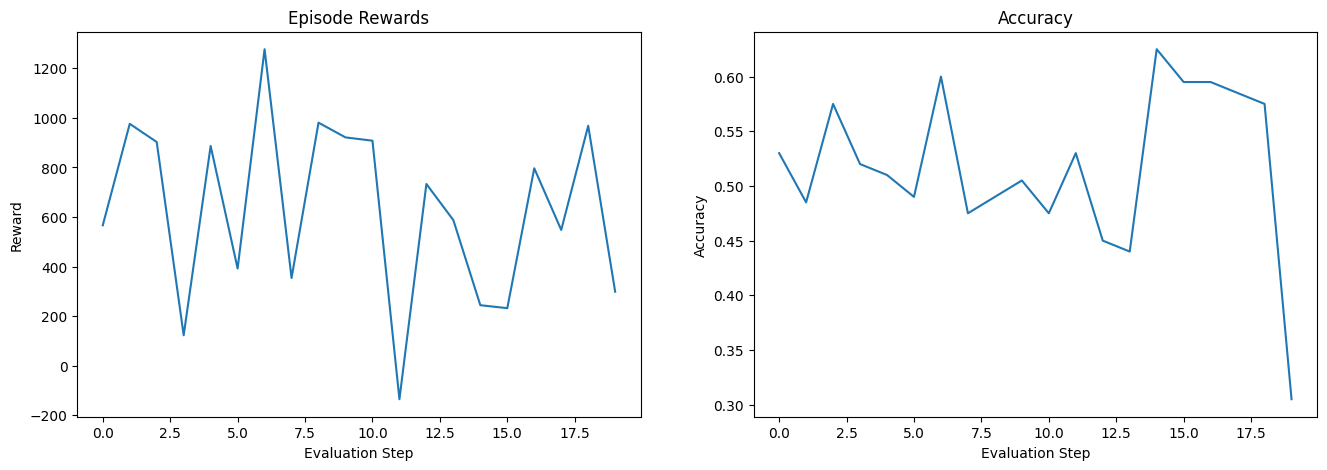

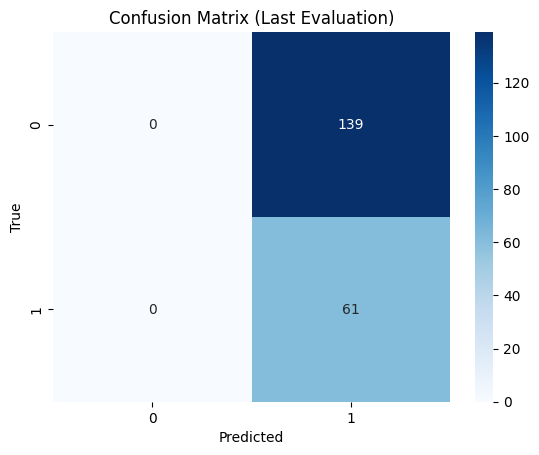

ValueError: Error: Unexpected observation shape (16,) for Box environment, please use (26,) or (n_env, 26) for the observation shape.

In [5]:
logger = train()
plot_metrics(logger)
test_model()